In [1]:
# tensorboard --logdir=logs
# http://desktop-bu5qmic:6006/

In [2]:
from __future__ import print_function

import argparse
import os
import random
import sys

import numpy as np

In [3]:
import shutil

# make or reset directory
def mk_reset_dir(directory):
    if os.path.exists(directory):
        try:
            shutil.rmtree(directory)
            os.mkdir(directory)
        except:
            print("error:", directory)
    else:
        try:
            os.mkdir(directory)
        except:
            print("error create:", directory)

In [4]:
# getting parent directory
project_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

In [5]:
# # setting data path data seperated by class name
# training_dir = "data\\input\\train"
# testing_dir = "data\\input\\test"
# validation_dir = "data\\input\\validation"

# # joining path with parent path 
# training_dir = os.path.join(project_dir, training_dir)
# testing_dir = os.path.join(project_dir, testing_dir)
# validation_dir = os.path.join(project_dir, validation_dir)


# # setting output directory
# model_dir =  "data\\output\\models"
# log_dir = "data\\output\\logs"

# # joining path with parent path 
# model_dir = os.path.join(project_dir, model_dir)
# log_dir = os.path.join(project_dir, log_dir)


In [6]:
training_dir = r'data/train'
validation_dir = r'data/validation'
testing_dir = r'data/test'
model_dir = 'output/models/'
log_dir = "output/logs"

model_file = model_dir+"weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"

In [7]:
from keras import metrics

# setting training parameters
norm = 255.0
rescale=1./norm
shear_range=0.2
zoom_range=0.2
horizontal_flip=True

# setting train, test, validation parameters
target_size=(224, 224)
batch_size=32
class_mode='categorical'

loss='categorical_crossentropy'
metrics=['accuracy']

epochs = 50
verbose = 1

C:\Users\Andromeda\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [60]:
mk_reset_dir(model_dir)
mk_reset_dir(log_dir)

error: output/logs


In [61]:
# model_file = "weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5"
# model_file = os.path.join(model_dir, model_file)

In [62]:
model_file

'output/models/weights-improvement-{epoch:02d}-{val_acc:.2f}.hdf5'

In [8]:
from keras.preprocessing.image import ImageDataGenerator

# data generator for training
train_datagen = ImageDataGenerator(
        rescale=rescale,
        shear_range=shear_range,
        zoom_range=zoom_range,
        horizontal_flip=horizontal_flip)

train_generator = train_datagen.flow_from_directory(
        training_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for validation
validation_datagen = ImageDataGenerator(rescale=rescale)
validation_generator = validation_datagen.flow_from_directory(
        validation_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

# data generator for testing
test_datagen = ImageDataGenerator(rescale=rescale)
test_generator = test_datagen.flow_from_directory(
        testing_dir,
        target_size=target_size,
        batch_size=batch_size,
        class_mode=class_mode)

Found 3031 images belonging to 5 classes.
Found 866 images belonging to 5 classes.
Found 426 images belonging to 5 classes.


In [9]:
from keras.applications.inception_v3 import InceptionV3

# importing inception model
base_model = InceptionV3(weights='imagenet', include_top=False)

In [10]:
from keras.layers import Dense, GlobalAveragePooling2D

# setting model layers specially output layer with class number
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)


In [11]:
from keras.models import Model

#loading model
model = Model(inputs=base_model.input, outputs=predictions)

In [12]:
# set all laeyrs as untrainable
for layer in base_model.layers:
    layer.trainable = False

In [13]:
from keras import optimizers

# chose and configure optimizer 
sgd = optimizers.Adam()
# sgd = optimizers.SGD()
# sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
# sgd = optimizer=SGD(lr=0.0001, momentum=0.9)

In [14]:
# compile model with optimizer and loss
model.compile(sgd, loss=loss, metrics=metrics)

In [15]:
#print layers of inception model
for i, layer in enumerate(base_model.layers):
    print(i, layer.name)

0 input_1
1 conv2d_1
2 batch_normalization_1
3 activation_1
4 conv2d_2
5 batch_normalization_2
6 activation_2
7 conv2d_3
8 batch_normalization_3
9 activation_3
10 max_pooling2d_1
11 conv2d_4
12 batch_normalization_4
13 activation_4
14 conv2d_5
15 batch_normalization_5
16 activation_5
17 max_pooling2d_2
18 conv2d_9
19 batch_normalization_9
20 activation_9
21 conv2d_7
22 conv2d_10
23 batch_normalization_7
24 batch_normalization_10
25 activation_7
26 activation_10
27 average_pooling2d_1
28 conv2d_6
29 conv2d_8
30 conv2d_11
31 conv2d_12
32 batch_normalization_6
33 batch_normalization_8
34 batch_normalization_11
35 batch_normalization_12
36 activation_6
37 activation_8
38 activation_11
39 activation_12
40 mixed0
41 conv2d_16
42 batch_normalization_16
43 activation_16
44 conv2d_14
45 conv2d_17
46 batch_normalization_14
47 batch_normalization_17
48 activation_14
49 activation_17
50 average_pooling2d_2
51 conv2d_13
52 conv2d_15
53 conv2d_18
54 conv2d_19
55 batch_normalization_13
56 batch_norma

In [16]:
# train the top 2 inception blocks 
# freeze first 249 layers
# unfreeze the rest

for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [17]:
import keras

checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
# checkpoint = keras.callbacks.ModelCheckpoint(model_file, monitor='val_acc')

In [18]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)


# early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None)
# early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=0, verbose=0, mode='auto', baseline=None)

In [19]:
tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, batch_size=32, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)
# tensorboard = keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1, batch_size=32, write_graph=True, write_grads=False, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

tensorboard.set_model(model) 

In [20]:
# callbacks_list = [checkpoint, tensorboard, early_stopping]
callbacks_list = [checkpoint, tensorboard]

In [91]:
# train inception model
# fine-tuning the top 2 inception blocks and top Dense layers
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/15
95/95 [==============================] - 1384s 15s/step - loss: 0.2375 - acc: 0.9189 - val_loss: 1.0209 - val_acc: 0.7517
Epoch 2/15
95/95 [==============================] - 32233s 339s/step - loss: 0.1948 - acc: 0.9384 - val_loss: 0.7543 - val_acc: 0.8106
Epoch 3/15
95/95 [==============================] - 1599s 17s/step - loss: 0.1723 - acc: 0.9411 - val_loss: 1.1082 - val_acc: 0.7725


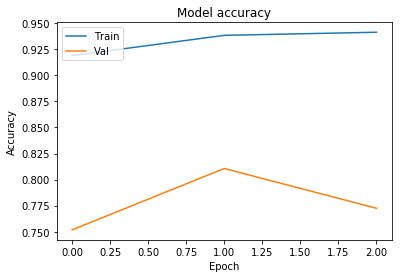

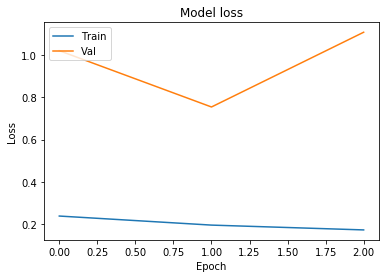

In [92]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
%matplotlib inline

# Plot training & validation accuracy values
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()

In [ ]:
#Retraining

In [98]:
# setting retraining from old model
model_path = "output/models/"+"weights-improvement-02-0.81.hdf5"
epochs=15
verbose=1

model = keras.models.load_model(model_path)

# retrain by loading last good model
history = model.fit_generator(
    train_generator,
    epochs=epochs,
    validation_data=validation_generator,
    callbacks=callbacks_list)

Epoch 1/15
95/95 [==============================] - 1897s 20s/step - loss: 0.1716 - acc: 0.9482 - val_loss: 0.9000 - val_acc: 0.8129
Epoch 2/15
95/95 [==============================] - 1879s 20s/step - loss: 0.1657 - acc: 0.9488 - val_loss: 0.8720 - val_acc: 0.8176
Epoch 3/15
95/95 [==============================] - 1830s 19s/step - loss: 0.1370 - acc: 0.9559 - val_loss: 1.0008 - val_acc: 0.7933


In [21]:
# testing model
model_path = "output/models/"+"weights-improvement-02-0.82.hdf5"
model = keras.models.load_model(model_path)

In [26]:
result = model.evaluate_generator(generator=test_generator)

In [27]:
print("%s%.2f%s"% ("Accuracy: ", result[1]*100, "%"))
print("%s%.2f"% ("Loss: ", result[0]))

Accuracy: 84.51%
Loss: 0.65


In [ ]:
# Best
# Accuracy: 85.68%
# Loss: 0.65

In [22]:
import re
def name_correct(name):
    return re.sub(r'[^a-zA-Z]', ' ', name).title()

In [23]:
preds = model.predict_generator(test_generator, verbose=1)
y_classes = preds.argmax(axis=-1)

14/14 [==============================] - 173s 12s/step


In [24]:
label_map = (test_generator.class_indices)
label_map_rev = {v: name_correct(k) for k,v in label_map.items()}

In [25]:
y_img_batch, y_class_batch = test_generator[0] 
y_pred = np.argmax(model.predict(y_img_batch),-1)
y_true = np.argmax(y_class_batch,-1)
print(sum(y_pred==y_true)/batch_size)

0.96875


In [26]:
y_true_labels = [label_map_rev[c] for c in y_true]
y_pred_labels = [label_map_rev[c] for c in y_pred]

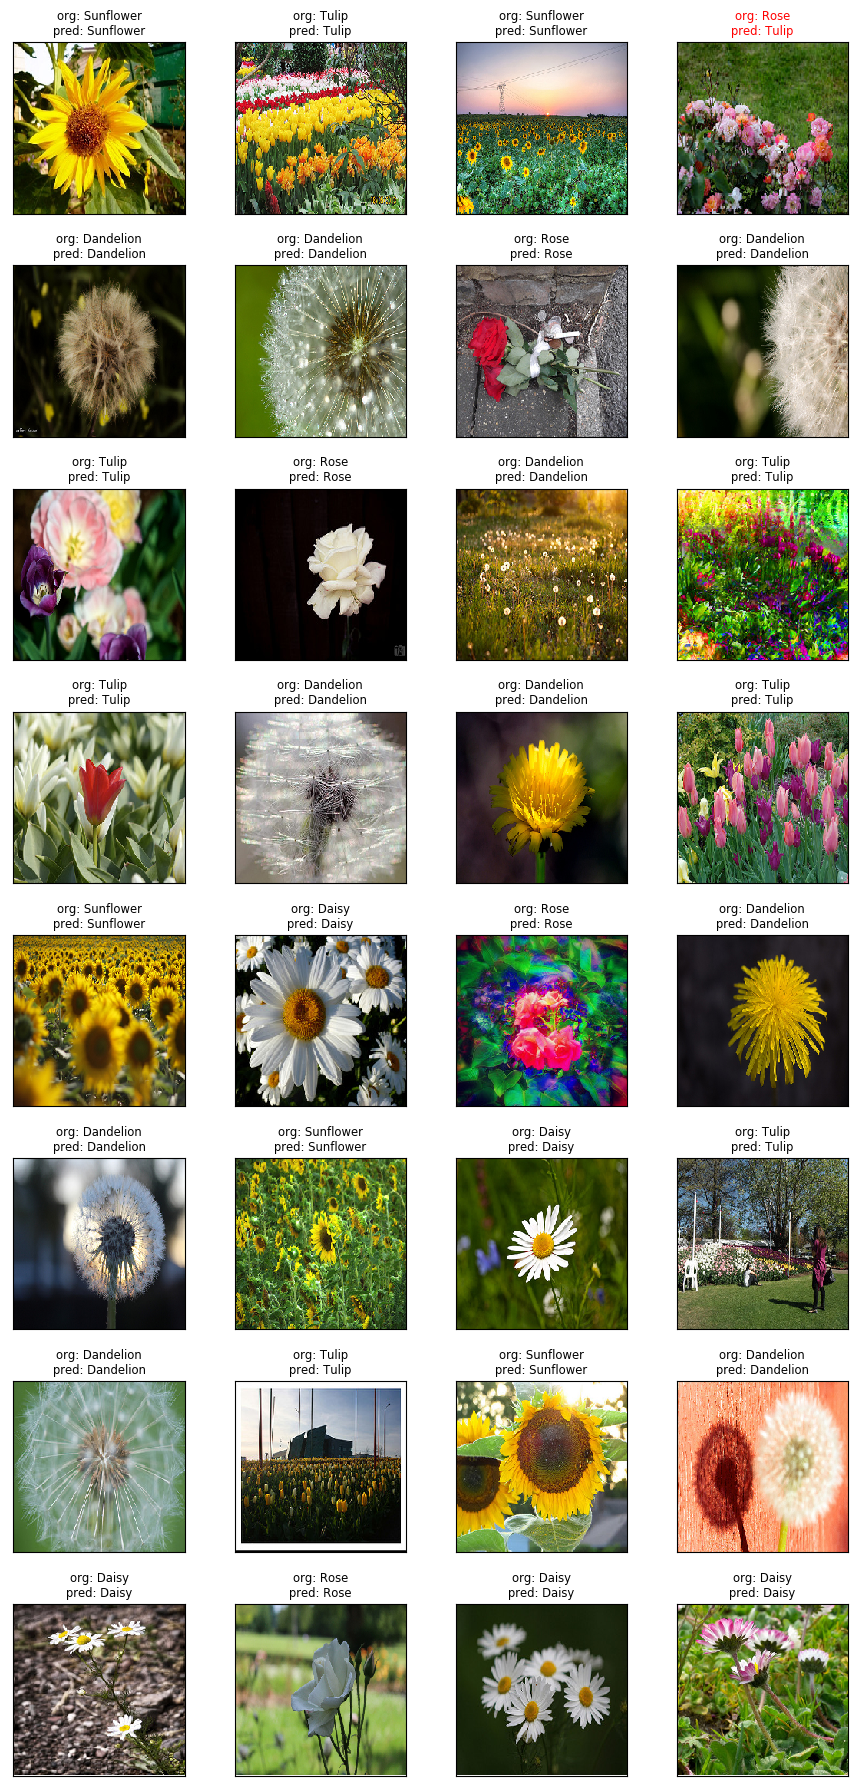

In [27]:
from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# figure(num=None, figsize=(8, 6), dpi=100, facecolor='w', edgecolor='k')

fig, axs = plt.subplots(nrows=8, ncols=4, figsize=(9, 18),
                        dpi=100, facecolor='w', edgecolor='k',
                        subplot_kw={'xticks': [], 'yticks': []})

plt.rcParams.update({'axes.titlesize': 'small'})
plt.subplots_adjust(hspace=0.3, wspace=0.3)


for i in range(0,32): # how many imgs will show from the 3x3 grid
    plt.subplot(8, 4, i+1)
    plt.imshow(y_img_batch[i])
    plt.xticks([])
    plt.yticks([])
    if y_true_labels[i]==y_pred_labels[i]:
        plt.title("org: " + y_true_labels[i] + "\npred: " + y_pred_labels[i])
    else:
        plt.title("org: " + y_true_labels[i] + "\npred: " + y_pred_labels[i], color='red')
        
    fig.savefig("result", dpi=100)
plt.tight_layout()
plt.show()
